In [3]:
from itertools import product
import sys

import numpy as np
from scipy import sparse
from scipy.sparse import eye as speye
from scipy.sparse.linalg import cg

from matplotlib import pyplot as plt, cm, colors

import networkx as nx

sys.path.append('../src')

from algraph import GraphThresholdActiveLearner
from parallel import GridParallel

In [86]:
class BernoulliSampler(object):
    
    def __init__(self, ps):
        self.ps = ps
        self.N = self.ps.size
    
    def __call__(self, i):
        return 1 if np.random.rand() < self.ps[i] else 0

class GaussianSampler(object):
    
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.N = self.mu.size
    
    def __call__(self, i):
        return self.mu[i] + np.random.randn() * self.sigma

def apply_APT(sampler, T, tau, epsilon):
    
    # initialize with two samples at all arms
    mu_cur = np.array([(sampler(i) + sampler(i)) / 2 for i in range(sampler.N)])
    ns = np.ones(sampler.N) * 2
    
    # apply APT
    mu_hats = np.zeros((T, sampler.N))
    for t in range(T):
        
        i = np.argmin(np.sqrt(ns) * (np.abs(mu_cur - tau) + epsilon))        
        mu_cur[i] = (mu_cur[i] * ns[i] + sampler(i)) / (ns[i] + 1)
        ns[i] += 1
        mu_hats[t, :] = mu_cur.copy()
        
    return mu_hats

def apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, alpha=1e-8, verbose=True):
    
    gapl = GraphThresholdActiveLearner(graph, tau, gamma, epsilon=epsilon, alpha=alpha)
    
    mu_hats = np.zeros((T, sampler.N))
    
    for t in range(T):
        
        if verbose:
            if (t > 0 and t % 1000 == 0) or t == T - 1:
                print('')
            if t % 10 == 0:
                print('.', end='')
        
        i = gapl.get_next_location()
        gapl.update(i, sampler(i))
        mu_hats[t, :] = gapl.mu_hat.copy()
    
    return mu_hats

def apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, alpha=1e-8, verbose=True):
    
    gapl = GraphThresholdActiveLearner(graph, tau, gamma, epsilon=epsilon, alpha=alpha)
    
    mu_hats = np.zeros((T, sampler.N))
    
    for t in range(T):
        
        if verbose:
            if (t > 0 and t % 1000 == 0) or t == T - 1:
                print('')
            if t % 10 == 0:
                print('.', end='')
        
        i = np.random.choice(sampler.N)
        gapl.update(i, sampler(i))
        mu_hats[t, :] = gapl.mu_hat.copy()
    
    return mu_hats

def failure_rate(mu, mu_hats, tau, epsilon):
    check_mask = (np.abs(mu - tau) > epsilon)
    return 1 - np.sum(((mu_hats[:, check_mask] - tau) * (mu[check_mask] - tau)[None, :]) > 0, 1) / mu.size

def compute_d(lamda, eigvals, H, M, mu_norm):
    
    q = 2 * H * (3 * M + 1) ** 2 * mu_norm ** 2 
    v = q / np.log(1 + q / lamda) / eigvals
    
    return np.sum(np.arange(len(v)) <= v)

def compute_optimal_gamma(L, mu, tau, epsilon, alpha, sigma, lamda=1e-3, gamma_0=10):
    
    H = np.sum(1 / (abs(mu - tau) + epsilon)**2)
    mu_norm = np.sqrt((mu - tau) @ ((L + lamda * speye(L.shape[0])) @ (mu - tau)))

    eigvals = np.sort(np.linalg.eigvalsh((L + lamda * speye(L.shape[0])).A))
    gamma = gamma_0

    # iterate a few times to settle any issues with M depending on gamma
    for i in range(100):
        M = max(np.sqrt(1 + alpha), np.sqrt(alpha / gamma / lamda))
        d = compute_d(lamda, eigvals, H, M, mu_norm)
        gamma = sigma / mu_norm * np.sqrt(2 * d * np.log(1 + 2 * H * (3 * M + 1) ** 2 * mu_norm ** 2 / lamda))
    
    return gamma

In [ ]:
def run_small_world_bernoulli(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, verbose=True):
    
    try:
        graph = nx.connected_watts_strogatz_graph(n, m, p)
    except Exception as e:
        print('Failed to generate connected Watts-Strogatz graph.')
        return None
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [ ]:
def run_small_world_bernoulli_random_laplacian(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, verbose=True):
    
    try:
        graph = nx.connected_watts_strogatz_graph(n, m, p)
    except Exception as e:
        print('Failed to generate connected Watts-Strogatz graph.')
        return None
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [ ]:
n = 10**3
m = 3
p = 0.2
lamda_gen = 1000
T = 5000
gammas = [0.1, 1, 10, 100, 1000]
tau = 0.5
epsilon = 1e-2

n_trials = 100

res = GridParallel(n_jobs=7, verbose=1)(run_small_world_bernoulli, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [False])
res_np = np.squeeze(res)
res_rand = GridParallel(n_jobs=7, verbose=1)(run_small_world_bernoulli_random_laplacian, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [False])
res_rand_np = np.squeeze(res_rand)

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in [0.1, 1, 10, 100, 1000]]:
    y = np.median(res_np[:, i, 0, :], 0)
    y_1q = np.percentile(res_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res_rand_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=100 random')
y = np.median(res_np[:, 0, 1, :], 0)
y_1q = np.percentile(res_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res_np[:, 0, 1, :], 75, 0)
plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [ ]:
np.savez('small_world_5000.npz', res_np=res_np, res_rand_np=res_rand_np)

In [82]:
def run_newman_small_world_bernoulli(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):
    
    graph = nx.newman_watts_strogatz_graph(n, m, p)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    if gamma == 'opt':
        gamma = compute_optimal_gamma(L, mu, tau, epsilon, alpha, 1 / 2)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [6]:
def run_newman_small_world_bernoulli_random_laplacian(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):
    
    graph = nx.newman_watts_strogatz_graph(n, m, p)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [87]:
n = 10**3
m = 4
p = 0.01
lamda_gen = 1000
T = 5000
gammas = [1, 100, 10000]
tau = 0.5
epsilon = 1e-2
alpha = 1e-8

n_trials = 100

res2 = GridParallel(n_jobs=7, verbose=1)(run_newman_small_world_bernoulli, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [alpha], [False])
res2_np = np.squeeze(res2)
res2_opt = GridParallel(n_jobs=7, verbose=1)(run_newman_small_world_bernoulli, n_trials*[n], [m], [p], [lamda_gen], [T], ['opt'], [tau], [epsilon], [alpha], [False])
res2_opt_np = np.squeeze(res2_opt)
res2_rand = GridParallel(n_jobs=7, verbose=1)(run_newman_small_world_bernoulli_random_laplacian, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [alpha], [False])
res2_rand_np = np.squeeze(res2_rand)

Number of tasks: 300.


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed: 25.2min


Number of tasks: 100.


[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed: 35.0min finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  3.8min


Number of tasks: 300.


[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:  9.6min finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed: 15.4min
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed: 24.9min finished


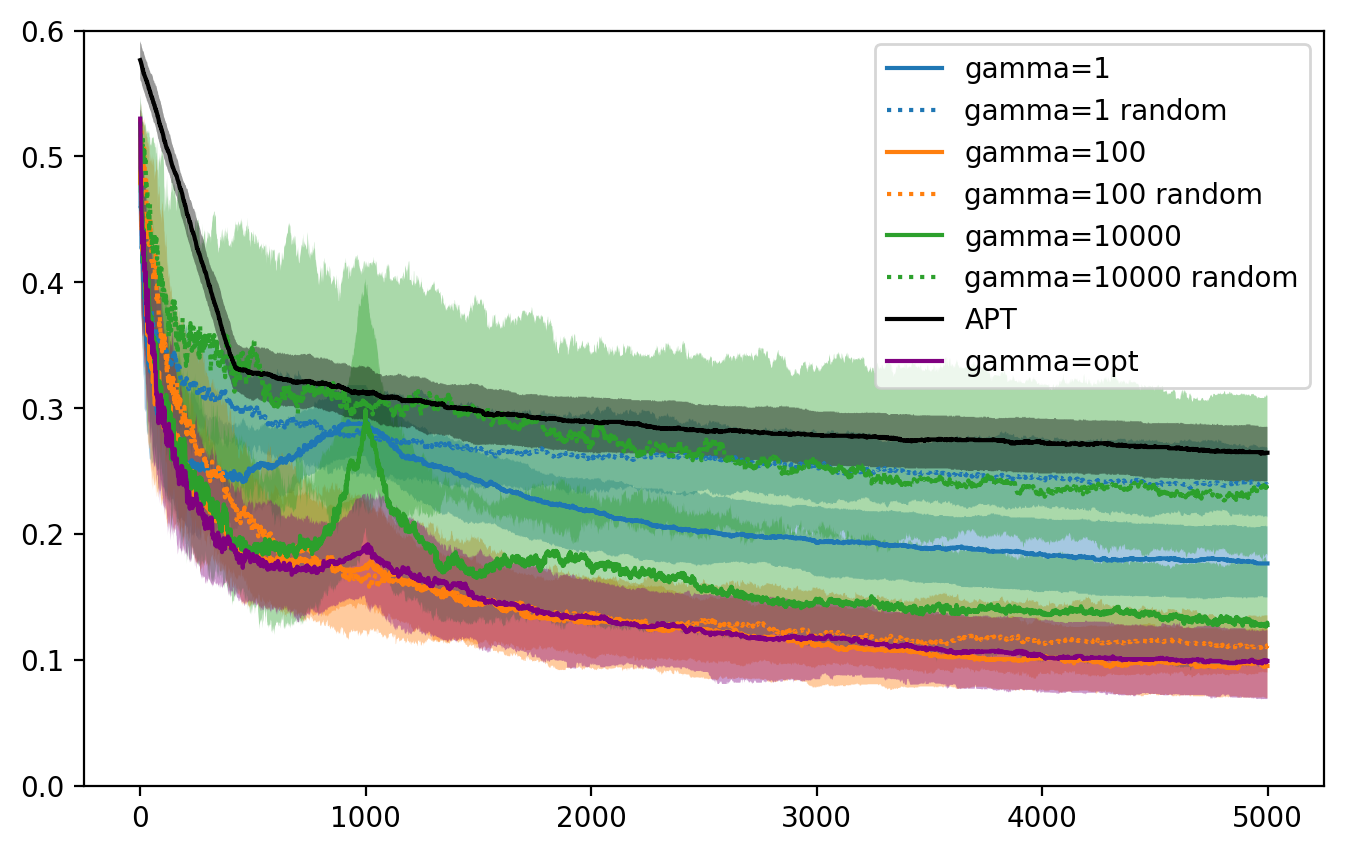

In [88]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in gammas]:
    y = np.median(res2_np[:, i, 0, :], 0)
    y_1q = np.percentile(res2_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res2_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res2_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res2_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res2_rand_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=%g random' % gammas[i])
y = np.median(res2_np[:, 0, 1, :], 0)
y_1q = np.percentile(res2_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res2_np[:, 0, 1, :], 75, 0)
plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
y = np.median(res2_opt_np[:, 0, :], 0)
y_1q = np.percentile(res2_opt_np[:, 0, :], 25, 0)
y_3q = np.percentile(res2_opt_np[:, 0, :], 75, 0)
plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='purple', alpha=0.4)
plt.plot(y, c='purple', label='gamma=opt')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [89]:
np.savez('newman_small_world_5000.npz', res2_np=res2_np, res2_opt_np=res2_opt_np, res2_rand_np=res2_rand_np)

In [76]:
def run_sbm_binary(n, sigma, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):
    
    p_inner = np.log(n // 2) / (n // 2)
    p_cross = p_inner / np.sqrt(n // 2)
    graph = nx.stochastic_block_model([n // 2, n - n // 2], [[p_inner, p_cross], [p_cross, p_inner]])
    #graph = max(nx.connected_component_subgraphs(graph), key=len)
    #n = len(graph)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate smooth signal and clip to [0, 1]
    mu = np.ones(n)
    mu[n // 2:] = -1
    
    #sampler = BernoulliSampler(mu)
    sampler = GaussianSampler(mu, sigma)
    
    if gamma == 'opt':
        gamma = compute_optimal_gamma(L, mu, tau, epsilon, alpha, sigma)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [38]:
def run_sbm_binary_random_laplacian(n, sigma, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):

    p_inner = np.log(n // 2) / (n // 2)
    p_cross = p_inner / np.sqrt(n // 2)
    graph = nx.stochastic_block_model([n // 2, n - n // 2], [[p_inner, p_cross], [p_cross, p_inner]])
    #graph = max(nx.connected_component_subgraphs(graph), key=len)
    #n = len(graph)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate class signal
    mu = np.ones(n)
    mu[n // 2:] = -1
    
    #sampler = BernoulliSampler(mu)
    sampler = GaussianSampler(mu, sigma)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [74]:
n = 10**3
sigma = 2
T = 5000
gammas = [1, 10, 100]
tau = 0
epsilon = 1e-2
alpha = 0.1

n_trials = 2

res3 = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res3_np = np.squeeze(res3)
res3_opt = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary, n_trials*[n], [sigma], [T], ['opt'], [tau], [epsilon], [alpha], [False])
res3_opt_np = np.squeeze(res3_opt)
res3_rand = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary_random_laplacian, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res3_rand_np = np.squeeze(res3_rand)

Number of tasks: 6.
Number of tasks: 2.


[Parallel(n_jobs=7)]: Done   6 out of   6 | elapsed:    9.5s finished


18.7384288241
19.7496090812
Number of tasks: 6.


[Parallel(n_jobs=7)]: Done   2 out of   2 | elapsed:   10.8s finished
[Parallel(n_jobs=7)]: Done   6 out of   6 | elapsed:    8.3s finished


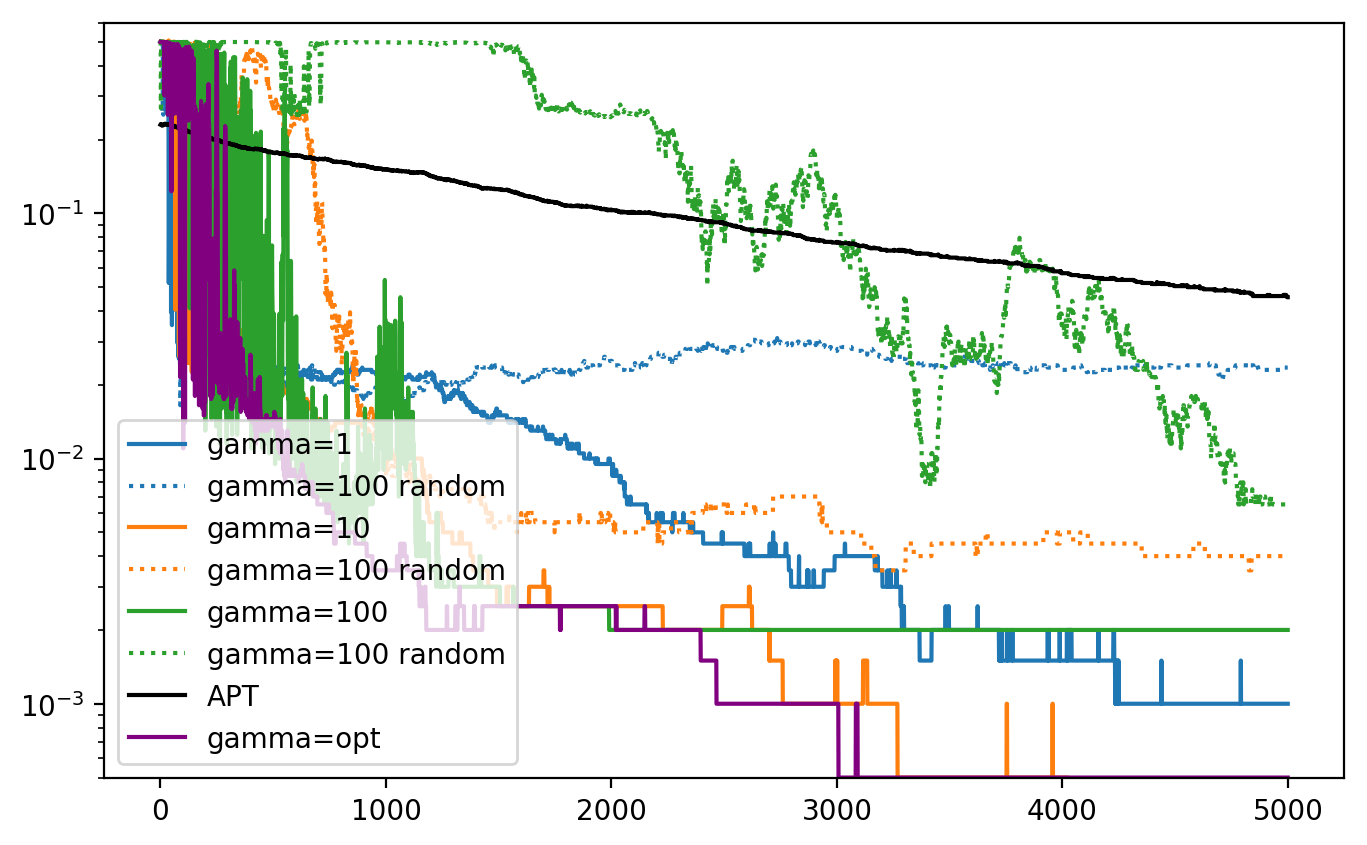

In [75]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in [1, 10, 100]]:
    y = np.median(res3_np[:, i, 0, :], 0)
    y_1q = np.percentile(res3_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res3_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.semilogy(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res3_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res3_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res3_rand_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=100 random')
y = np.median(res3_np[:, 0, 1, :], 0)
y_1q = np.percentile(res3_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res3_np[:, 0, 1, :], 75, 0)
#plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
y = np.median(res3_opt_np[:, 0, :], 0)
y_1q = np.percentile(res3_opt_np[:, 0, :], 25, 0)
y_3q = np.percentile(res3_opt_np[:, 0, :], 75, 0)
#plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='purple', alpha=0.4)
plt.plot(y, c='purple', label='gamma=opt')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [12]:
np.savez('sbm_binary.npz', res3_np=res3_np, res3_opt_np=res3_opt_np, res3_rand_np=res3_rand_np)

In [70]:
n = 10**3
sigma = 2
T = 5000
gammas = [1, 10, 100]
tau = 0
epsilon = 1e-2
alpha = 1

n_trials = 100

res4 = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res4_np = np.squeeze(res4)
res4_opt = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary, n_trials*[n], [sigma], [T], ['opt'], [tau], [epsilon], [alpha], [False])
res4_opt_np = np.squeeze(res4_opt)
res4_rand = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary_random_laplacian, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res4_rand_np = np.squeeze(res4_rand)

Number of tasks: 300.


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   58.4s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  4.9min


Number of tasks: 100.


[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:  7.9min finished


20.6372710888
19.6356877223
20.0461033214
19.837597893
21.0355028063
19.0662194089
19.5697899347
20.2615740208
18.9464902679
18.9464902679
20.4092868855
19.3129065183
20.2615740208
19.9063492054
20.6372710888
21.0355028063
18.7138753236
20.793734487
19.9063492054
20.0461033214
19.7022800055
19.2503057623
19.1883312515
19.0662194089
19.9063492054
21.3718918454
21.546483779
20.0461033214
19.5045745646
18.8290667729
19.837597893
19.6356877223
22.1944232423
19.5697899347
20.2615740208
21.2016238125
19.6356877223
19.1269725359
20.3350136172
20.7150436518
20.3350136172
19.3129065183


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  3.5min


19.0662194089
19.0662194089
20.0461033214
20.1171338658
19.7022800055
19.6356877223
19.7695791648
20.5603989429
20.9539449189
19.7022800055
20.6372710888
19.1883312515
19.7022800055
20.1889525002
19.7695791648
19.5697899347
20.3350136172
19.837597893
18.7711965131
19.0060619
19.7695791648
20.7150436518
18.7711965131
19.0060619
21.0355028063
21.1180555864
22.1944232423
20.1171338658
19.837597893
20.6372710888
20.1171338658
19.3129065183
20.4844098431
20.6372710888
19.7695791648
19.1883312515
18.8290667729
18.7711965131
19.9063492054
18.7138753236
19.1269725359
19.9063492054
19.7022800055
19.6356877223
19.5045745646
18.6008455778
21.1180555864
20.793734487
21.8168926534
20.0461033214
17.7669285654
20.7150436518
19.5697899347
19.5697899347
19.1269725359
19.0662194089
20.793734487
18.8290667729
Number of tasks: 300.


[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:  8.7min finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   58.2s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  4.8min
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:  7.7min finished


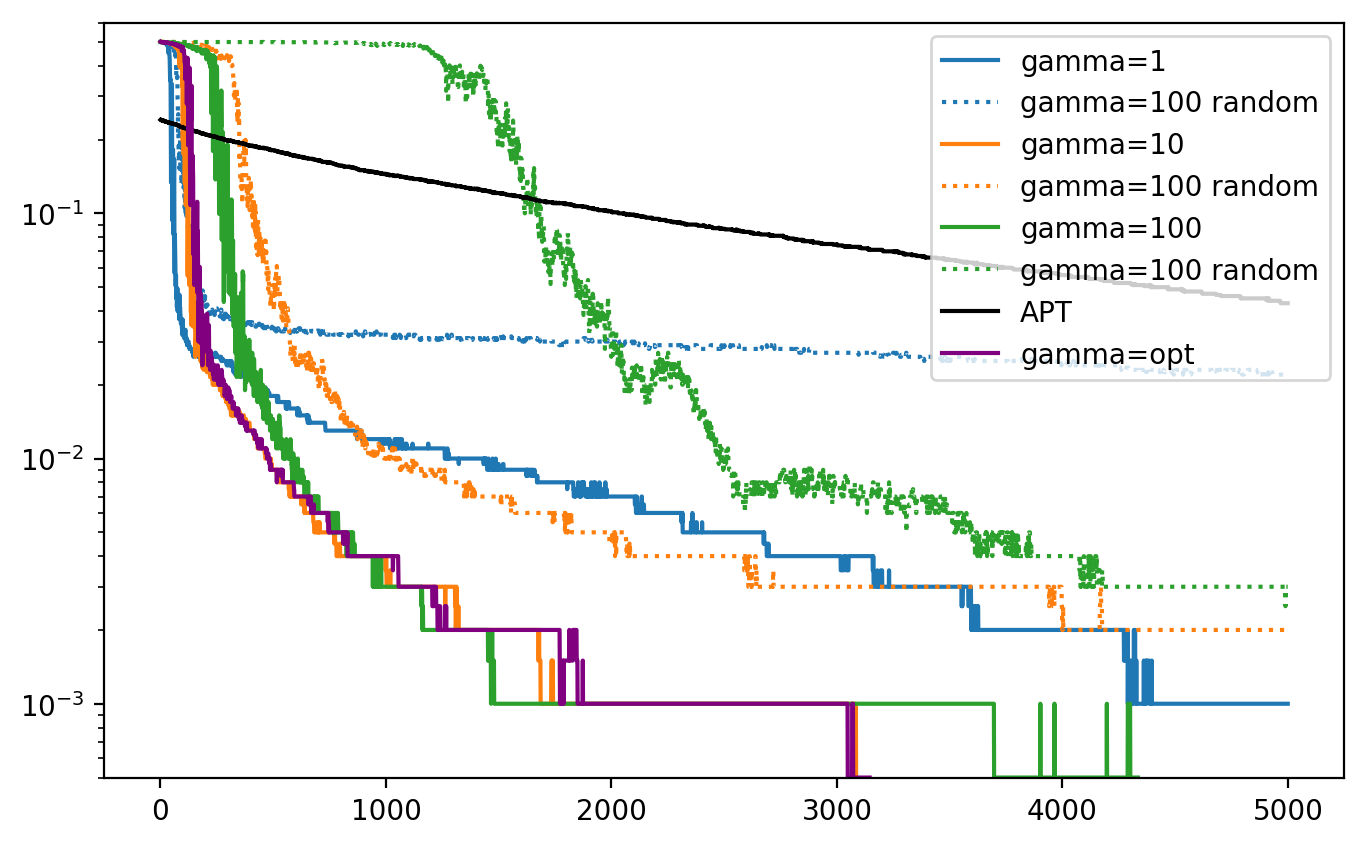

In [71]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in [1, 10, 100]]:
    y = np.median(res4_np[:, i, 0, :], 0)
    y_1q = np.percentile(res4_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res4_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.semilogy(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res4_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res4_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res4_rand_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=100 random')
y = np.median(res4_np[:, 0, 1, :], 0)
y_1q = np.percentile(res4_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res4_np[:, 0, 1, :], 75, 0)
#plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
y = np.median(res4_opt_np[:, 0, :], 0)
y_1q = np.percentile(res4_opt_np[:, 0, :], 25, 0)
y_3q = np.percentile(res4_opt_np[:, 0, :], 75, 0)
#plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='purple', alpha=0.4)
plt.plot(y, c='purple', label='gamma=opt')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [72]:
np.savez('sbm_binary_alpha_1.npz', res4_np=res4_np, res4_opt_np=res4_opt_np, res4_rand_np=res4_rand_np)